# Question: Is there a meaningful drop-out rate at any grade and if so, are there any indicators for it?

Concrete questions:

	1- What is the percentage of dropout rates per municipality?
	2- Is it related to the class sizes?
	3- Is it related to income level?
	4- Do we have data to relate this to facility conditions?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

Data Sources:
https://open.alberta.ca/opendata/alberta-school-and-school-authority-student-population

In [33]:
authority_student_population = pd.read_csv('alberta-school-authority-student-population-data.csv')
student_population = pd.read_csv('alberta-school-student-population-data.csv')

# Do schools change their authority?

In [51]:
# Clean up the school year name to numeric values
student_population['year'] = student_population['School Year Name']\
.apply(lambda x: x.split('/')[0] if type(x) == str else np.nan)\
.apply(lambda x: int(x) if type(x) == str and len(x) == 4 else np.nan)

# Get the previous years school authority for each school
student_population['Prev School Authority Code'] = student_population\
.sort_values('year', ascending = True)\
.groupby('School Code')['School Authority Code'].shift(1)

# Keep only the rows that previous year's district is different than this year's
distcit_change = student_population[
    (student_population['Prev School Authority Code'] != student_population['School Authority Code']) &
    (~student_population['Prev School Authority Code'].isna())
]

In [111]:
# Number of schools that changed their district each year
temp1 = distcit_change.groupby('year')\
.count()['School Code']\
.reset_index().rename(columns = {'School Code': 'Schools that changed district'})

# Total number of schools each year
temp2 = student_population.groupby('year')\
.agg({'School Code': 'nunique'})\
.reset_index().rename(columns = {'School Code': 'total number of schools'})

# Number of schools that changed their authorithy each year compared to the total number of schools that year
num_changed = pd.merge(
    temp1,
    temp2,
    how = 'inner',
    on = 'year'
)
num_changed

,year,Schools that changed district,total number of schools
0,1996.0,4,2047
1,1997.0,122,2050
2,1998.0,144,2018
3,1999.0,12,2039
4,2000.0,6,2050
5,2001.0,96,2067
6,2002.0,2,2067
7,2003.0,2,2071
8,2004.0,3,2098
9,2005.0,54,2095


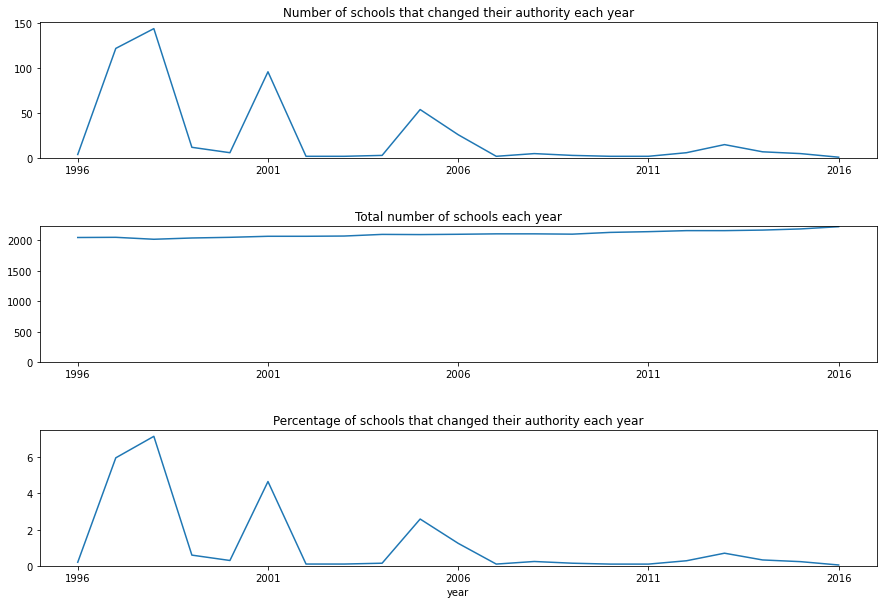

In [261]:
plt.figure(figsize=[15,10])
plt.subplots_adjust(hspace = .5)
plt.subplot(3,1,1)
plt.plot(
    num_changed['year'],
    num_changed['Schools that changed district']
)
plt.title('Number of schools that changed their authority each year')
plt.xticks(num_changed['year'][::5])
plt.ylim(bottom = 0)

plt.subplot(3,1,2)
plt.plot(
    num_changed['year'],
    num_changed['total number of schools']
)
plt.title('Total number of schools each year')
plt.xticks(num_changed['year'][::5])
plt.ylim(bottom = 0)


plt.subplot(3,1,3)
plt.plot(
    num_changed['year'],
    100 * num_changed['Schools that changed district']/ num_changed['total number of schools']
)
plt.xlabel('year')
plt.title('Percentage of schools that changed their authority each year')
plt.xticks(num_changed['year'][::5])
plt.ylim(bottom = 0)


plt.show()

In [268]:
# average rate of change in total number of schools per year
100 * np.mean(((num_changed['total number of schools'] / num_changed['total number of schools'].shift(1)) - 1).dropna())

0.4201810361584818

##### results: 

- Schools do change districts but it is negligible compared to the total number of schools and this is happening less and less
- Total number of schools is increasing over time slowly. (0.4% yearly increase) 

# Load yearly data

Data Source: https://open.alberta.ca/opendata/class-size-by-school-year-jurisdiction-and-grade-alberta

In [109]:
# # combine data
# class_sizes = pd.DataFrame()
# for year in range(2004, 2019):
#      class_sizes = class_sizes.append(pd.read_csv('csis_{}.csv'.format(year)), ignore_index = True)
# class_sizes.to_csv('csis_2004_2018.csv', index = False)
class_sizes = pd.read_csv('csis_2004_2018.csv')

In [269]:
# Some subject id's have more than 1 subject name
class_sizes.subject_id.nunique(), class_sizes.subject_nm.nunique()

(26, 28)

In [279]:
subjects = pd.DataFrame(class_sizes.groupby('subject_id')['subject_nm'].apply(lambda x: list(set(x)))).reset_index()
msubj = subjects[subjects['subject_nm'].apply(lambda x: len(x)) > 1]
for _, row in msubj.iterrows():
    print("subject id '{}' represents:\n\t{}".format(row.subject_id, row.subject_nm))

subject id '1' represents:
	['English/French Language Arts', 'Language Arts English/French']
subject id '21' represents:
	['Knowledge and Employability', 'Integrated Occupational Program']


In [280]:
# GradeGroup_id seems to be well defined and consistent across all
class_sizes.GradeGroup_id.unique()

array([1, 2, 3, 4])

In [281]:
# csiz_id seems to be a reporting id, each row has a unique value
class_sizes.shape[0] - class_sizes.csiz_id.nunique()

0

In [282]:
# No idea what sch_cd is
class_sizes.sch_cd.nunique()

1700

In [283]:
# It seems like 'Grade' is not very well defined in this data set
# here are a few values
sorted(class_sizes.grade.unique())[:20]

['/10/11',
 '/8/9/10/11/12',
 '/9/10/11/12',
 '0',
 '0/1/2',
 '0/1/2/4/5',
 '001',
 '001/02',
 '002',
 '003',
 '003/02',
 '007/08/09',
 '01',
 '01//02',
 '01/01',
 '01/02',
 '01/02/03',
 '01/02/03/',
 '01/02/03/04',
 '01/02/03/04/']

# Is there a significant drop out rate?

In [166]:
# clean up the data
# student_population.fillna(0, inplace = True)
# student_population.drop([46148, 46149, 46150], inplace = True)

In [171]:
# add up all the students for each year and grade
yearly_pop = student_population[['year'] + ['Grade {}'.format(i) for i in range(1,13)]]\
.groupby('year')\
.agg({'Grade {}'.format(i): 'sum' for i in range(1,13)}).reset_index()

In [189]:
# Calculate the change in each year's grade to NEXT year's NEXT grade
for i in range(1,12):
    yearly_pop['drop_{}'.format(i)] = yearly_pop['Grade {}'.format(i+1)].shift(-1) - yearly_pop['Grade {}'.format(i)]

In [193]:
# This is what the population looks like
yearly_pop[['year'] + ['Grade {}'.format(i) for i in range(1,12)]].head()

,year,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11
0,1995.0,43799.0,42167.0,41212.0,42207.0,42675.0,42745.0,42804.0,41316.0,39656.0,42039.0,37853.0
1,1996.0,43825.0,42705.0,42149.0,41469.0,42463.0,42912.0,43102.0,43075.0,41097.0,44004.0,40471.0
2,1997.0,43394.0,43048.0,42873.0,42667.0,42000.0,42972.0,43898.0,43724.0,43185.0,45572.0,41554.0
3,1998.0,43290.0,42948.0,43355.0,43484.0,43358.0,42572.0,43993.0,44360.0,43730.0,47229.0,43410.0
4,1999.0,42288.0,42530.0,42958.0,43743.0,43916.0,43593.0,43198.0,44381.0,44341.0,47957.0,45478.0


In [194]:
# This is what the change in population looks like
yearly_pop[['year'] + ['drop_{}'.format(i) for i in range(1,12)]].head()

,year,drop_1,drop_2,drop_3,drop_4,drop_5,drop_6,drop_7,drop_8,drop_9,drop_10,drop_11
0,1995.0,-1094.0,-18.0,257.0,256.0,237.0,357.0,271.0,-219.0,4348.0,-1568.0,9062.0
1,1996.0,-777.0,168.0,518.0,531.0,509.0,986.0,622.0,110.0,4475.0,-2450.0,8043.0
2,1997.0,-446.0,307.0,611.0,691.0,572.0,1021.0,462.0,6.0,4044.0,-2162.0,8879.0
3,1998.0,-760.0,10.0,388.0,432.0,235.0,626.0,388.0,-19.0,4227.0,-1751.0,9368.0
4,1999.0,-715.0,155.0,429.0,455.0,352.0,528.0,423.0,-229.0,3322.0,-1754.0,11054.0


For example, from 44K students enrolled in grade 1 in 1995, 43K made it to grade 2 in year 1996. That's a drop rate of 1K for gradr 1 of 1995. Approximately -2%.

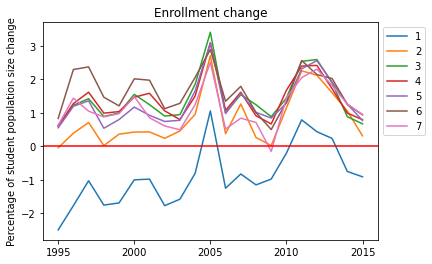

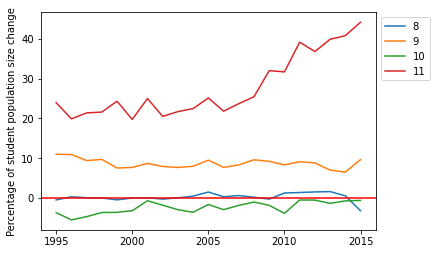

In [284]:
for i in range(1,8):
    plt.plot(
        yearly_pop.year.astype('int32'),
        100 * yearly_pop['drop_{}'.format(i)] / yearly_pop['Grade {}'.format(i)],
        label = i
    )
plt.axhline(0, color = 'r')
plt.xticks(yearly_pop.year[::5])
plt.legend(bbox_to_anchor = [1,1], loc = 'upper left')
plt.title('Enrollment change')
plt.ylabel('Percentage of student population size change')

plt.show()

for i in range(8,12):
    plt.plot(
        yearly_pop.year.astype('int32'),
        100 * yearly_pop['drop_{}'.format(i)] / yearly_pop['Grade {}'.format(i)],
        label = i
    )
plt.axhline(0, color = 'r')
plt.xticks(yearly_pop.year[::5])
plt.ylabel('Percentage of student population size change')

plt.legend(bbox_to_anchor = [1,1], loc = 'upper left')
plt.show()

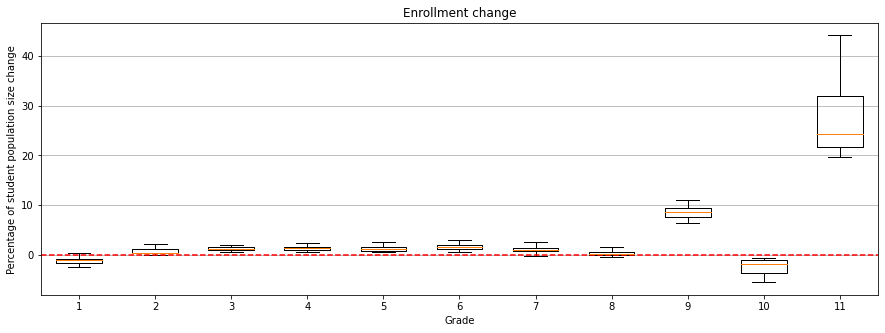

In [285]:
plt.figure(figsize=[15,5])
for j in range(1,12):
    y = yearly_pop['drop_{}'.format(j)] / yearly_pop['Grade {}'.format(j)]
    y.dropna(inplace = True)
    plt.boxplot(
        100 * y,
        positions = [j],
        showfliers = False,
        widths = .6
    )
plt.axhline(0, color = 'r', linestyle = '--')
plt.title('Enrollment change')
plt.xlabel('Grade')
plt.ylabel('Percentage of student population size change')
plt.gca().get_yaxis().grid()
plt.show()

#### Results:
- Seems like the enrollment change is not just because of students dropping out, it probably also relates to students repeating the same grade resulting in a positive change in numbers.

#### Next:
- Still same questions as above can be asked, but the interpretation now will have to change, relating municipality to the change in enrollment relating to both repating a grade and dropping out. Not sure what conclusions can come out of it though.
- To understand the existense and reason for dropout rate, we have to look at the other data sets, ideally per student, but it is highly unlikely to obtain that data set for privacy reasons.
- 2005 and 2011-12 see an influx of students across all grades, what is the cause of these?
- Grade 11 enrollment change keeps increasing over time, how can this be explained?

Other data sources to explores:
- Employement rate: https://regionaldashboard.alberta.ca/#/explore-an-indicator?i=employment-rate&d=CalculatedValue
- Median Family income: https://regionaldashboard.alberta.ca/#/explore-an-indicator?i=median-family-income&d=CalculatedValue
- internet access across canada: https://open.alberta.ca/dataset/proportion-of-households-with-access-to-the-internet-for-canada-alberta-economic-regions-2010/resource/68e00a17-0f92-4da3-a774-6f585c2c5754